In [0]:


from google.colab import files
import pystan
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as sts
uploaded = files.upload() 


import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['weekly_in_situ_co2_mlo.csv'].decode('utf-8')))

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo.csv



# This project uses the CO2 level data from the Muana-Loa observatory in Hawaai and implements a PyStan Model to understand the pattern and predict Co2 levels for 40 years in advance


# Data Consolidation and preprocessing

In [0]:
from datetime import datetime
from datetime import date
from datetime import timedelta

print((datetime.strptime(df.Date[3090],'%d/%m/%Y').date() -  datetime.strptime(df.Date[0],'%d/%m/%Y').date()).days/7)
print('Missing weeks: ' + str(3161 - 3091))

3161.0
Missing weeks: 70


In [0]:
weeks  = []
years = []
timestamps = []

# Using this algorithm to collect the timestamps and also the number of weeks as the time variable


for stamp in df.Date:
  
  first = date(1958,3,29)
  current = datetime.strptime(stamp,'%d/%m/%Y').date()
  timestamps.append(current)
  difference = (current - first).days
  weeks.append(difference/7)

# Real Data Variation

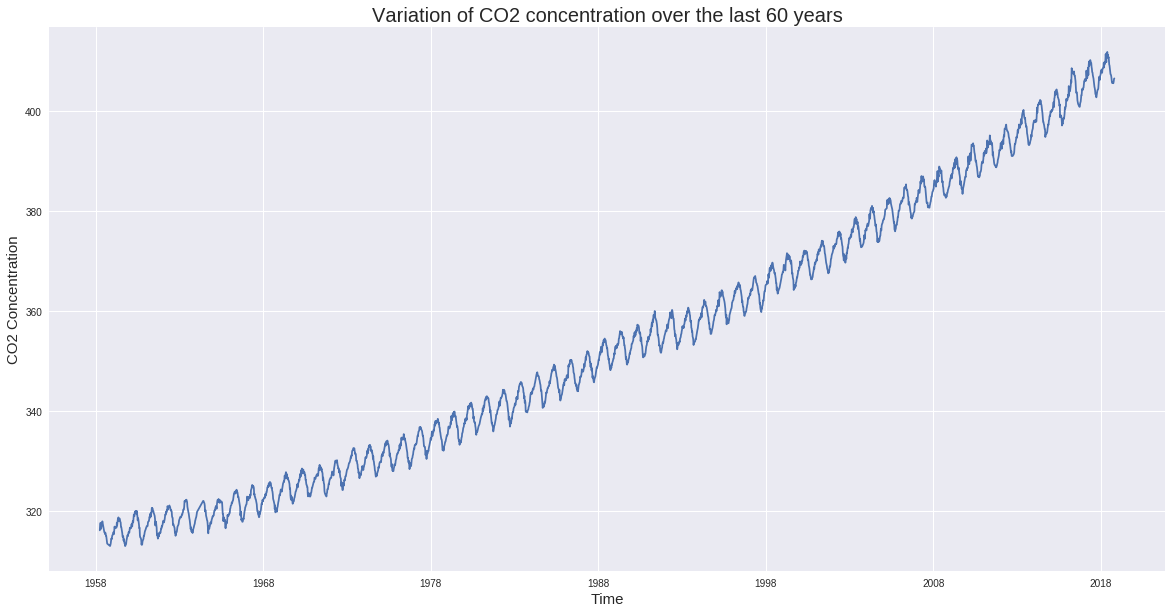

In [0]:
# Plotting the real dataset

plt.figure(figsize=(20,10))
plt.plot(timestamps,df.ppm)
plt.title('Variation of CO2 concentration over the last 60 years',fontsize=20)
plt.xlabel('Time',fontsize=15)
plt.ylabel('CO2 Concentration',fontsize=15)
plt.show()

In [0]:
# Creating the time for 40 years into the future

future_weeks = 40*52
last_date = date(2018,10,27)
last_week = weeks[3090]

for i in range(1,future_weeks + 1):
  weeks.append(last_week + i)
  timestamps.append(last_date +timedelta(days=7*i))

# Building the PyStan Model

In [0]:
stan_code_1 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> N;  // number of datapoints
    int<lower=1> N_future; // total number of datapoints from 1958 to 2058
    real<lower=0> ppm[N];  // C02 concentration data
    real<lower=0> week[N_future]; // time variable
    real<lower=0> period; // period of the first since curve
    real<lower=0> period2; // period of the second sine curve
    real<lower=0> c6_meanvariance; // mean of the variance prior
    real<lower=0> amp1; // mean of the amplitude prior of the first sine curve
    real<lower=0> amp2; // mean of the amplitude prior of the second sine curve
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real<lower=0> c1; // intercept
    real<lower=0> c2; // linear coefficient
    real<lower=0> c3; // quadratic coefficient
    real<lower=0> c4; // amplitude of the first sine curve
    real<lower=0> c5; // amplitude of the second sine curve
    real<lower=0> c6; // variance mean
    real phi_x; // phase 1 hyperpriors
    real phi_y; // phase 1 hyperpriors
    
    real phi2_x; // phase 2 hyperpriors
    real phi2_y; // phase 2 hyperpriors
    
}

transformed parameters {
    real<lower= -pi(),upper = pi()> phi; // phase of the first sine curve
    real<lower= -pi(),upper = pi()> phi2; // phase of the second sine curve
    phi = atan2(phi_x, phi_y);
    phi2 = atan2(phi2_x, phi2_y);
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    
    c1 ~ normal(315,5); // normal prior centered at approximate expected value
    c2 ~ normal(0.01,0.1); // normal priors for the expected values of the coefficients
    c3 ~ normal(0.01,0.1);
    c4 ~ normal(amp1,1); // centering the priors on expected amplitude with enough variance
    c5 ~ normal(amp2,1);
    c6 ~ normal(c6_meanvariance,1); // gaussian prior for noise
    
    phi_x ~ normal(0, 1); // phase hyperprior
    phi_y ~ normal(0, 1); // phase hyperprior
    
    phi2_x ~ normal(0, 1); // phase hyperprior
    phi2_y ~ normal(0, 1); // phase hyperprior
    
    for (j in 1:N){ // likelihood function
    
      ppm[j] ~ normal(c1 + c2*week[j]+ c3*(week[j])^2 + c4*sin((2*pi()/period)*week[j] + phi) + c5*sin((2*pi()/period2)*week[j] + phi2), c6);
    }
    
}

generated quantities{
  real ppm_pred[N_future]; // generating the replicated datasets from 1958 to 2018
  for(j in 1:N_future){
    ppm_pred[j] = normal_rng(c1 + c2*week[j]+ c3*(week[j])^2 + c4*sin((2*pi()/period)*week[j] + phi) + c5*sin((2*pi()/period2)*week[j] + phi2), c6) ; 
    // This is our posterior predictive distribution and additional scenario predictions
    
    
    }

}

"""

In [0]:
c2_slope = (df.ppm[3090] - df.ppm[0])/weeks[3090]
print(c2_slope)

0.028573236317621004


In [0]:
data = {
        'N': 3091,
        'N_future': 3091 + future_weeks,
        'ppm': df.ppm,
        'week': weeks, 
        'c6_meanvariance': 3,
        'period': 2000,
        'period2': 52.17,
        'amp1': 1,
        'amp2': 3,
}

In [0]:
!pip install pystan

In [0]:
stan_model_1 = pystan.StanModel(model_code=stan_code_1) # Compiling the model

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d67695fbe78b0b94ef7cbcb88ff0c1df NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpkd99gv27/stanfit4anon_model_d67695fbe78b0b94ef7cbcb88ff0c1df_9141108765772668903.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


# Sampling

In [0]:
stan_results_1 = stan_model_1.sampling(data=data) #Sampling

In [0]:
parameters = ['c1','c2','c3','c4','c5','c6','phi','phi2']

print(stan_results_1.stansummary(pars=parameters))

Inference for Stan model: anon_model_d67695fbe78b0b94ef7cbcb88ff0c1df.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1   315.31  1.4e-3   0.05 315.21 315.28 315.31 315.35 315.42   1533    1.0
c2     0.01  2.3e-6 7.7e-5   0.01   0.01   0.01   0.01   0.01   1167    1.0
c3   5.0e-6 6.9e-10 2.4e-8 5.0e-6 5.0e-6 5.0e-6 5.1e-6 5.1e-6   1161    1.0
c4     0.83  5.4e-4   0.03   0.78   0.82   0.84   0.85   0.88   2305    1.0
c5     2.86  4.8e-4   0.02   2.81   2.84   2.86   2.87    2.9   1903    1.0
c6     0.84  3.5e-4   0.01   0.82   0.83   0.84   0.85   0.86    966    1.0
phi    3.03  9.4e-3   0.55   3.02   3.06   3.08    3.1   3.13   3387    1.0
phi2   1.12  1.2e-4 7.5e-3   1.11   1.12   1.12   1.13   1.14   4228    1.0

Samples were drawn using NUTS at Thu Dec 20 21:48:33 2018.
For each parameter, n_eff is a crude measure of effective sample si

In [0]:
posterior_samples = stan_results_1.extract()

In [0]:
# Extracting the mean predictions and the confidence intervals from the replicated datasets

ppm = posterior_samples['ppm_pred']
co2_replicated_trend = []
upper_bounds = []
lower_bounds = []

for i in range(0,3091 + future_weeks):
  co2_replicated_trend.append(np.mean(ppm[:,i]))
  
  upper_bounds.append(np.percentile(ppm[:,i],97.5)) ## Upper bound of 97.5 confidence intervals
  lower_bounds.append(np.percentile(ppm[:,i],2.5)) ## Lower bound of 97.5% confidence intervals

# Model Fit


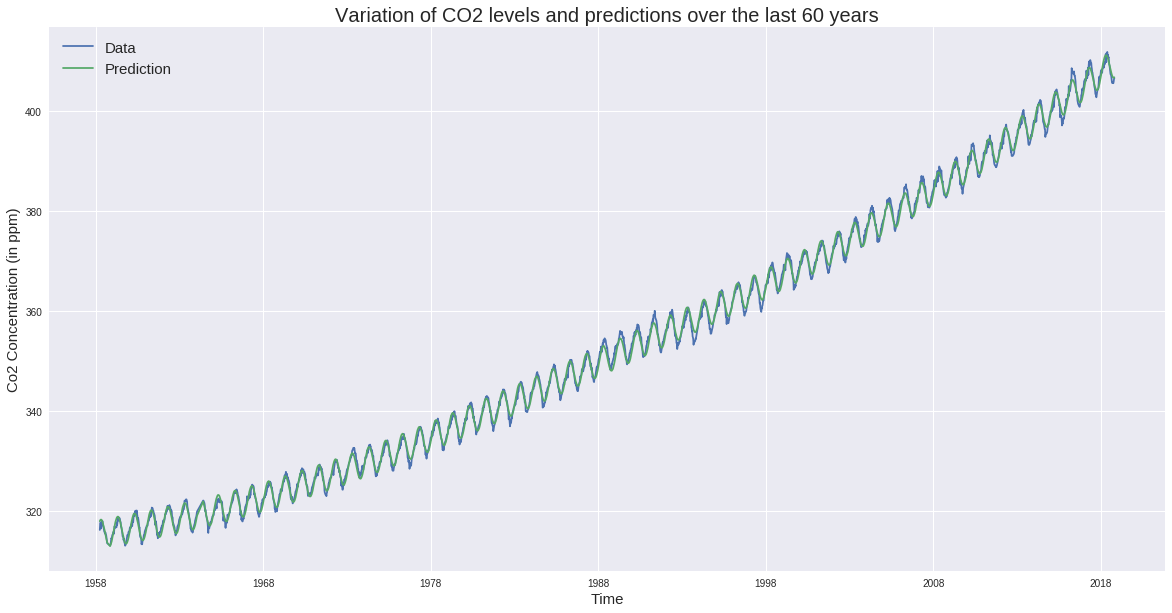

In [0]:
## Plotting the predictions with the real data

x = timestamps
y2 = co2_replicated_trend
y1 = df.ppm

plt.figure(figsize=(20,10))
plt.plot(x[0:3091],y1[0:],label='Data')
plt.plot(x[0:3091],y2[0:3091],label='Prediction')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Co2 Concentration (in ppm)',fontsize=15)
plt.title('Variation of CO2 levels and predictions over the last 60 years',fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Forecasting for the next 40 years

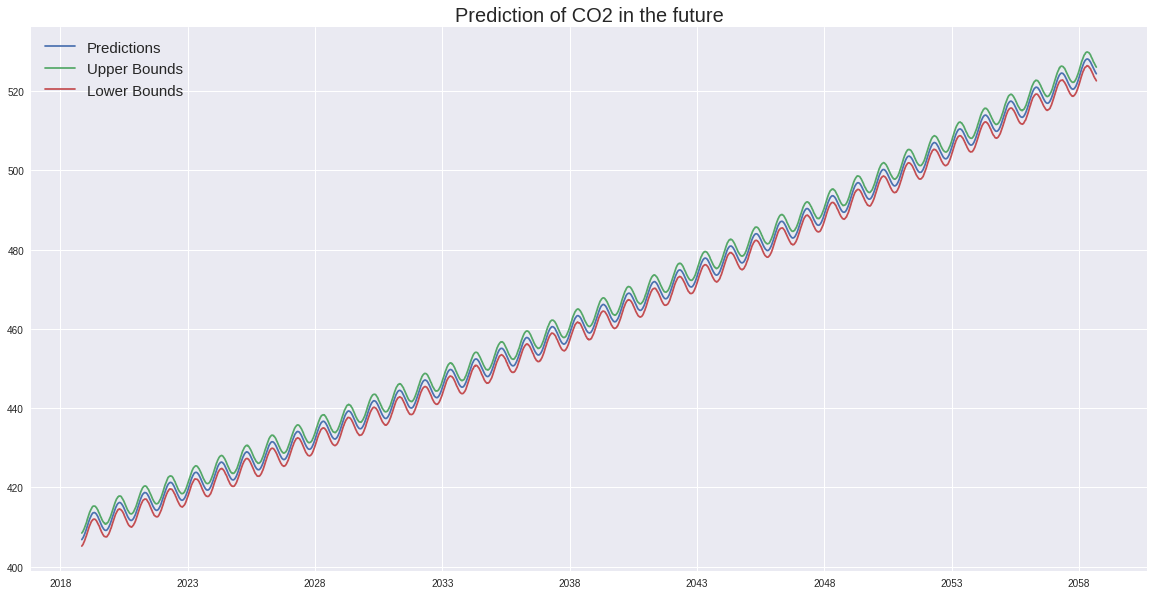

In [0]:
## Plotting the forecasts for the next 40 years

plt.figure(figsize=(20,10))
plt.title('Prediction of CO2 in the future',fontsize=20)
plt.plot(timestamps[3091:],co2_replicated_trend[3091:],label='Predictions')
plt.plot(timestamps[3091:],upper_bounds[3091:],label='Upper Bounds') 
plt.plot(timestamps[3091:],lower_bounds[3091:],label='Lower Bounds')
plt.legend(fontsize=15)
plt.show()

# Forecasting the timeline when CO2 crosses 450 ppm

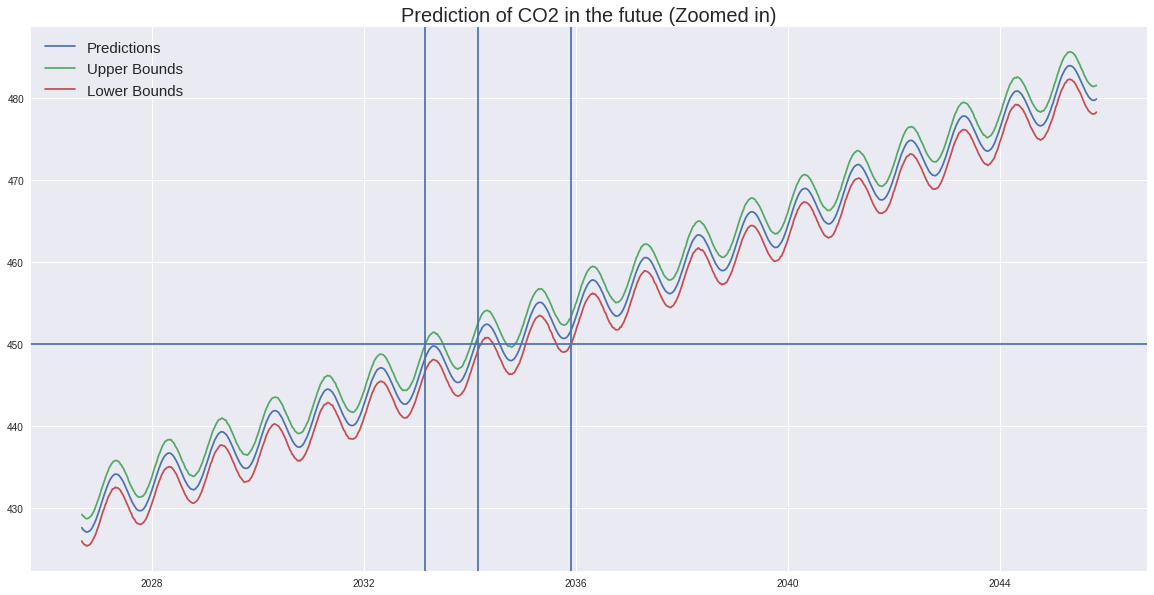

In [0]:
plt.figure(figsize=(20,10))
plt.title('Prediction of CO2 in the futue (Zoomed in)',fontsize=20)
plt.plot(timestamps[3500:4500],co2_replicated_trend[3500:4500],label='Predictions')
plt.plot(timestamps[3500:4500],upper_bounds[3500:4500],label='Upper Bounds')
plt.plot(timestamps[3500:4500],lower_bounds[3500:4500],label='Lower Bounds')
plt.axhline(450)
plt.axvline(date(2033,3,1))
plt.axvline(date(2034,3,1))
plt.axvline(date(2035,12,1))
plt.legend(fontsize=15)
plt.show()

In [0]:
index = 5135
print('Estimate for 2058 Beginning: ' + str(co2_replicated_trend[5135]) + ' +- ' + str(upper_bounds[5135] - co2_replicated_trend[5135]))

Estimate for 2058 Beginning: 523.5729019741949 +- 1.7727958659340857


# Residuals

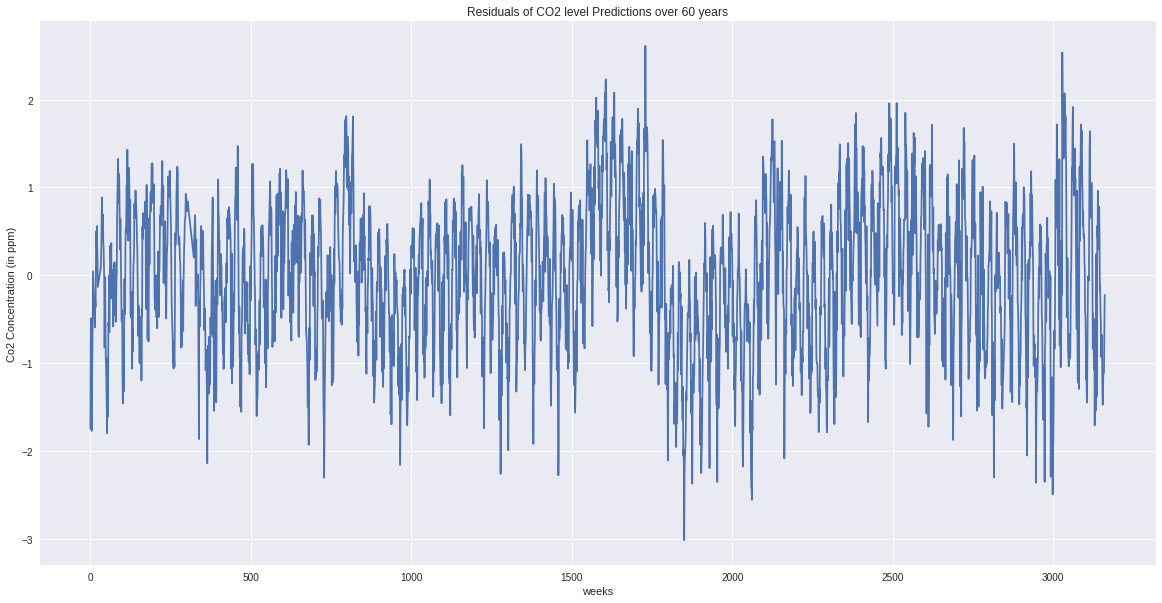

In [0]:
residuals = []
for i in range(0,3091):
  residuals.append(df.ppm[i] - co2_replicated_trend[i]) # Calculating the differences between the model and the mean predicted datasets

x = weeks[0:3091]
y = residuals

plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.xlabel('weeks')
plt.ylabel('Co2 Concentration (in ppm)')
plt.title('Residuals of CO2 level Predictions over 60 years')
plt.show()

# Autocorrelation Plots

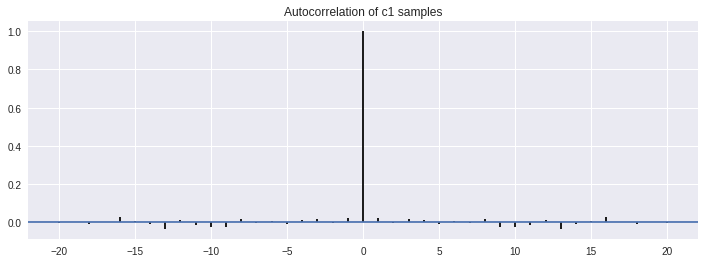

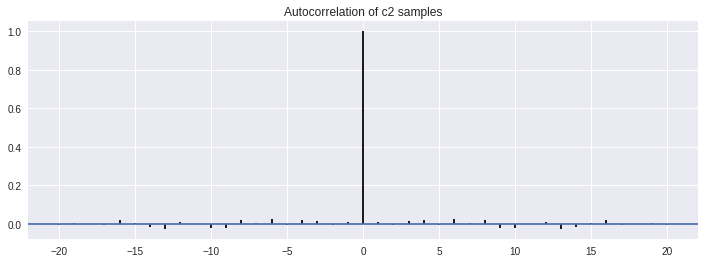

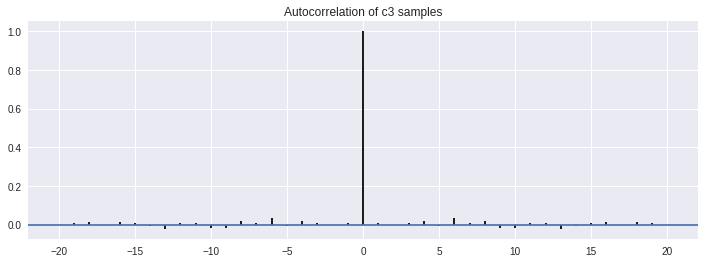

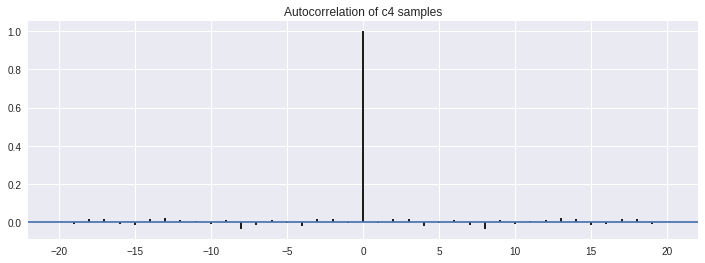

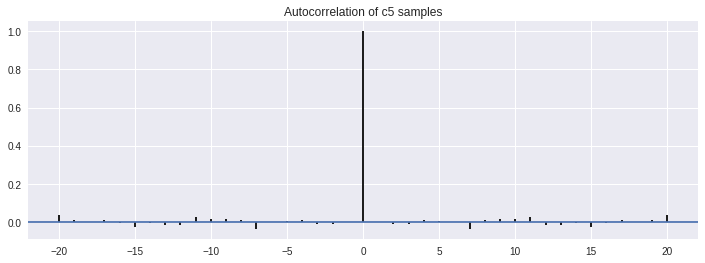

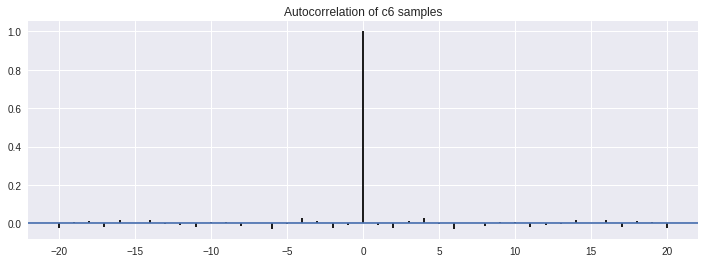

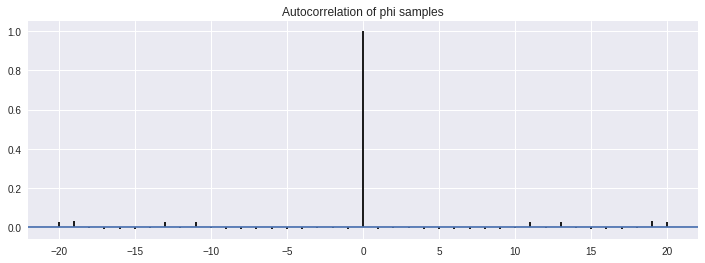

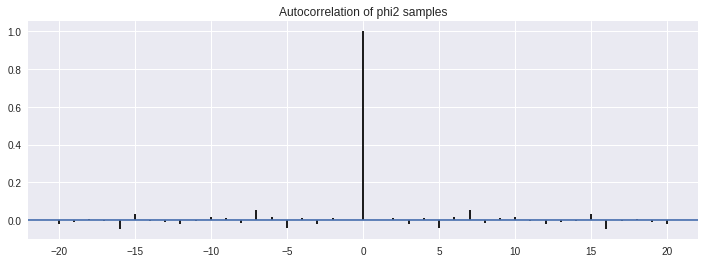

In [0]:
def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters: # Testing the autocorrelation in our posterior samples
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

    plt.show()

# Pair Plots

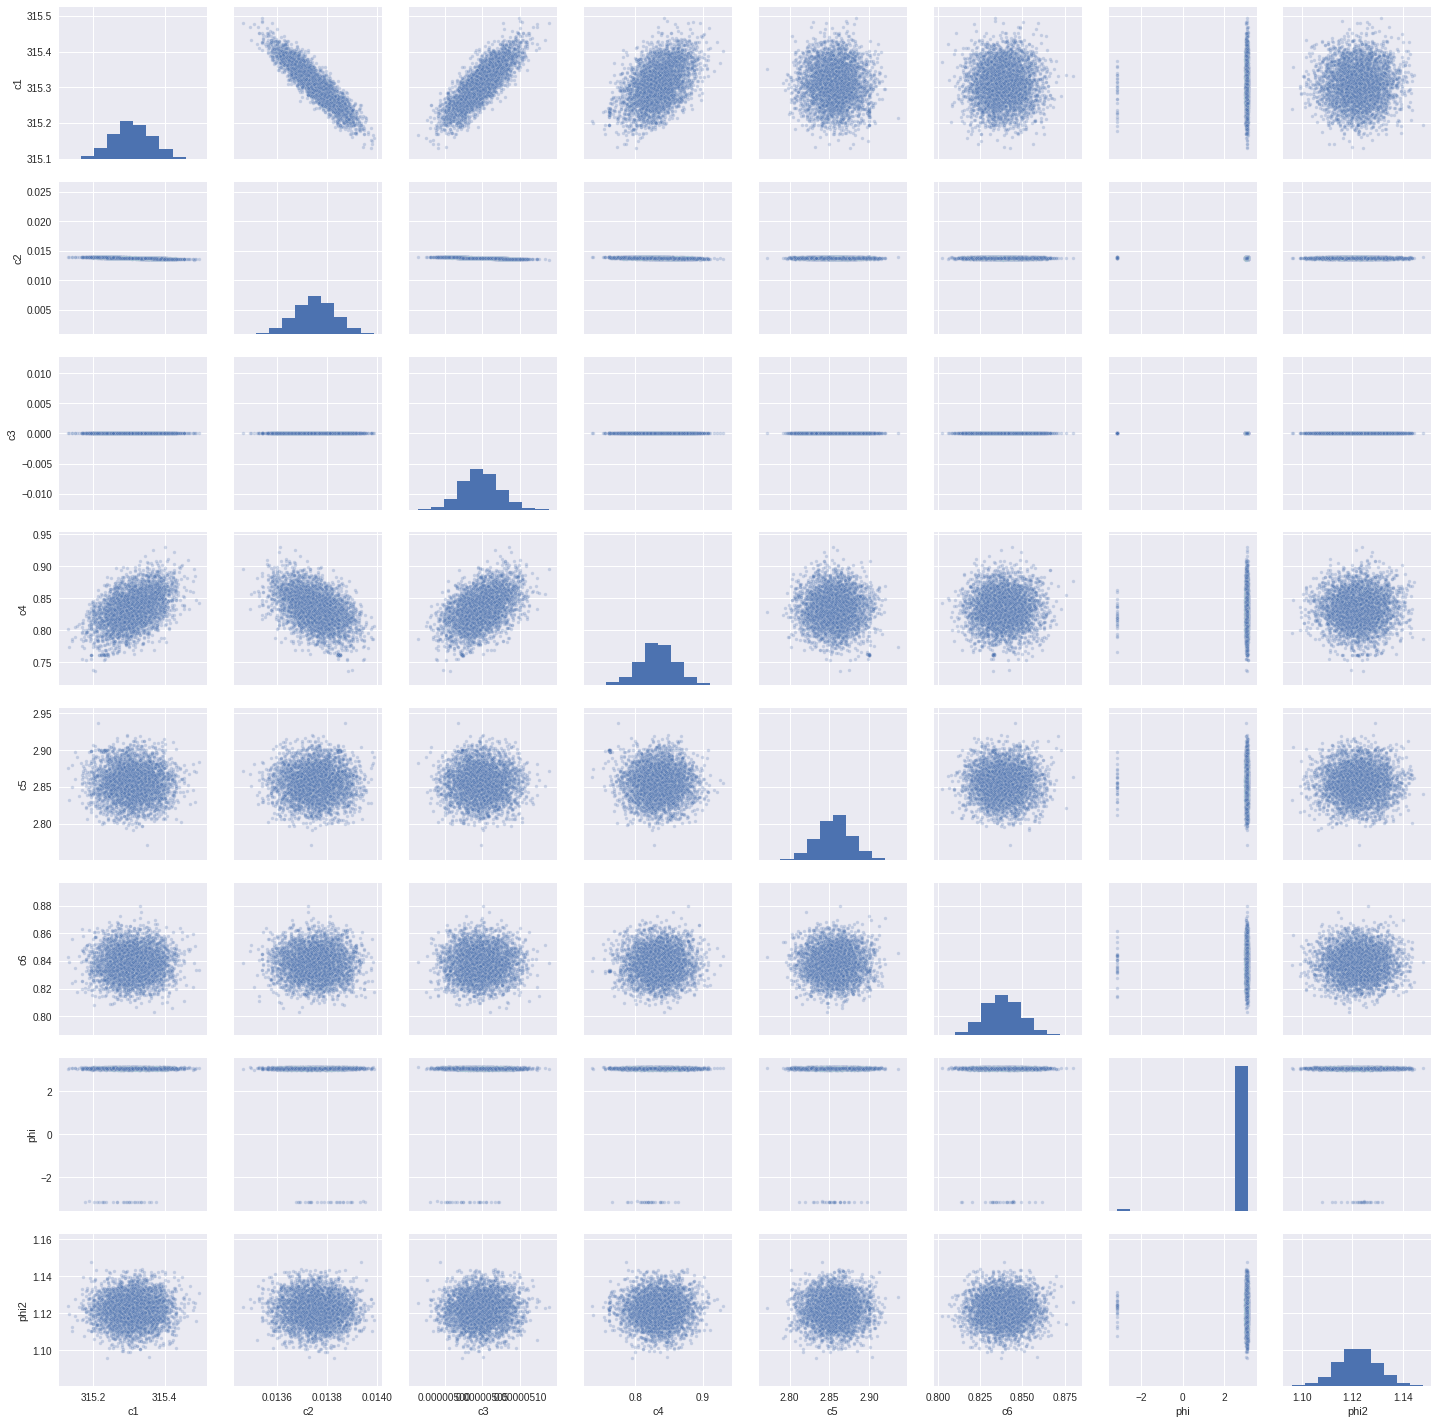

In [0]:
import seaborn
sample_df = pd.DataFrame(
    data=np.transpose([posterior_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(sample_df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

# Test Statistic Functions

In [0]:
def test_statistic2(replicated_datasets): # Mean Squared Errors
  
  mean_residuals = []
  
  for dataset in replicated_datasets:
    
    residuals = []
    for i in range(0,3091):
      residuals.append((df.ppm[i] - dataset[i])**2) # Calculating mean squared errors
    
    mean_residuals.append(np.mean(residuals))
  
  
  print('The p value for this test is ', sts.norm(np.mean(mean_residuals),np.std(mean_residuals)).cdf(0))
  
  plt.figure(figsize=(20,10))
  plt.hist(mean_residuals)
  plt.axvline(0,color='red',label ='Real Dataset Mean Squared Error')
  plt.title('Test Statistic Distribution for the Mean Squared Errors',fontsize=20)
  plt.legend(fontsize=15)
  plt.show()

The p value for this test is  0.0


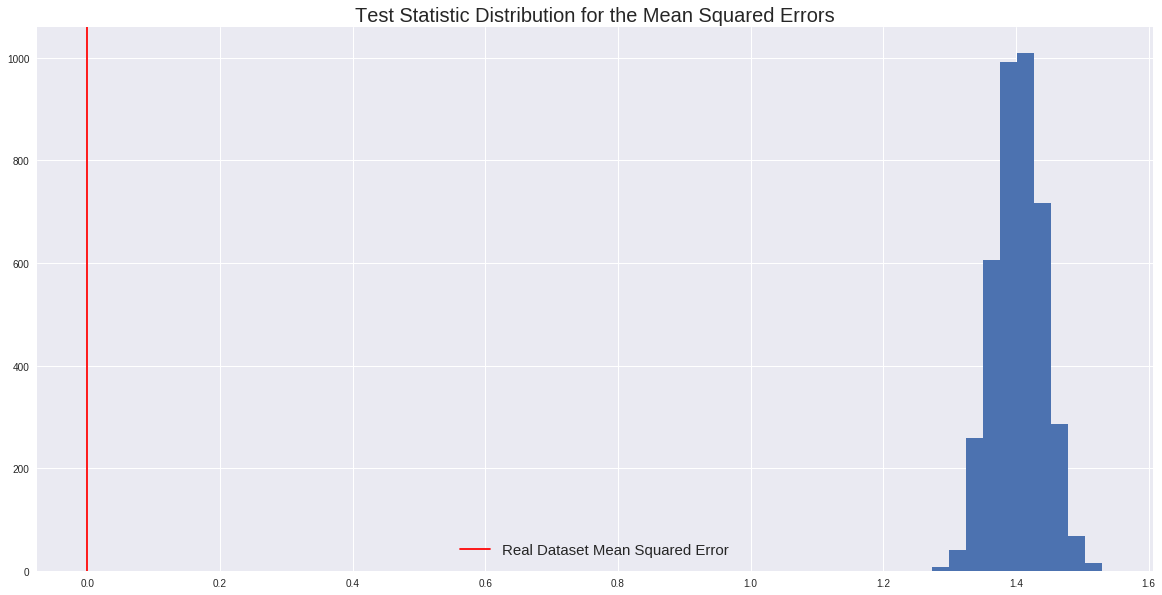

In [0]:
test_statistic2(ppm)

The p value for this test is  0.006397377450335948


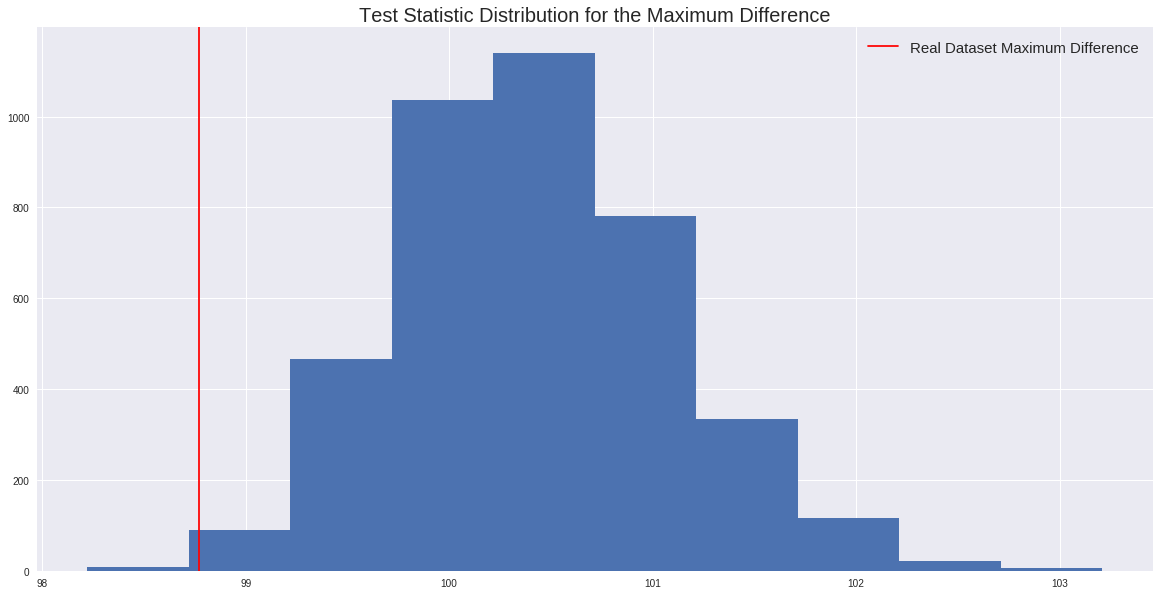

In [0]:
def test_statistic(replicated_datasets): # Mean difference of minimum and maximum value
  
  differences = []
  
  for dataset in replicated_datasets:
    
    diff = max(dataset[0:3091]) - min(dataset[0:3091])
    
    differences.append(diff)
  
  actual = max(df.ppm) - min(df.ppm)
  
  print('The p value for this test is ', sts.norm(np.mean(differences),np.std(differences)).cdf(actual))
  
  plt.figure(figsize=(20,10))
  plt.hist(differences)
  plt.axvline(actual,color='red',label ='Real Dataset Maximum Difference')
  plt.title('Test Statistic Distribution for the Maximum Difference',fontsize=20)
  plt.legend(fontsize=15)
  plt.show()
  
test_statistic(ppm)

# Posterior Distributions

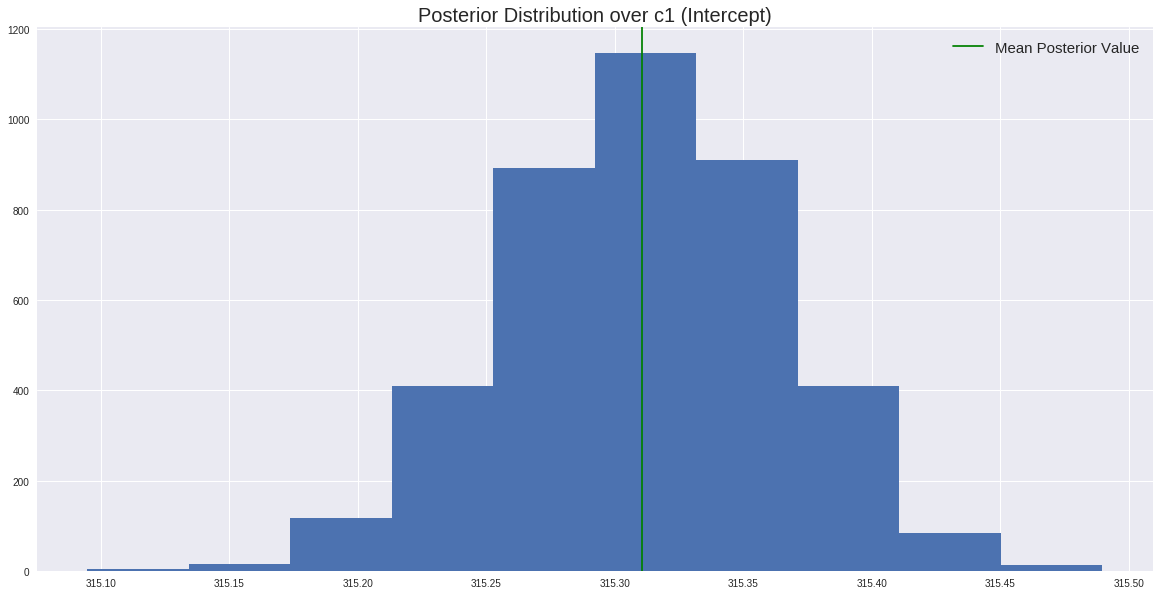

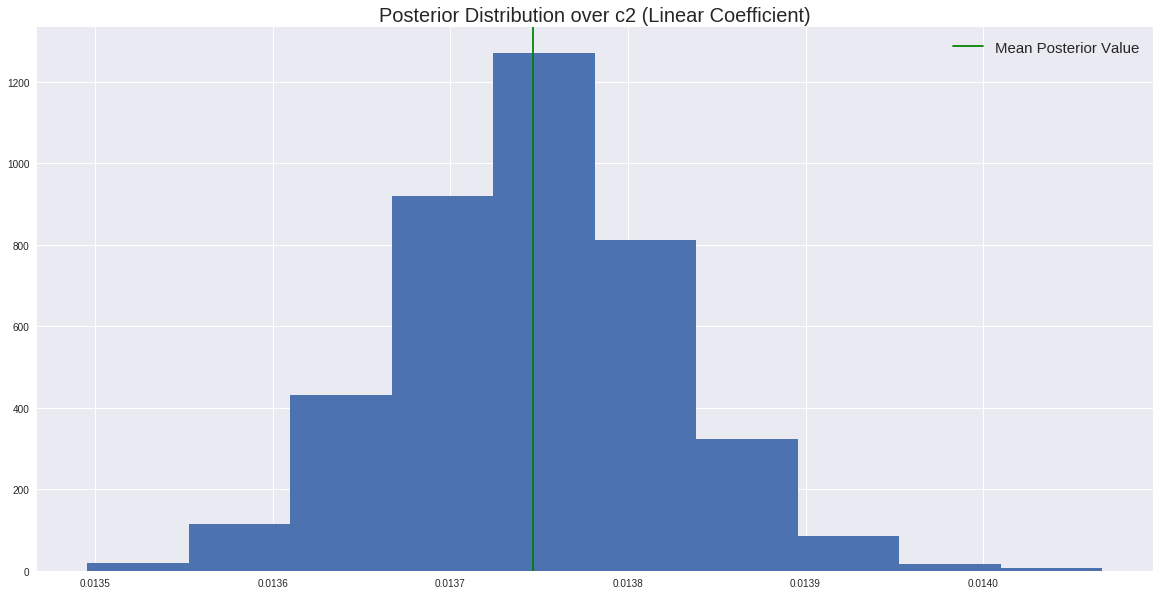

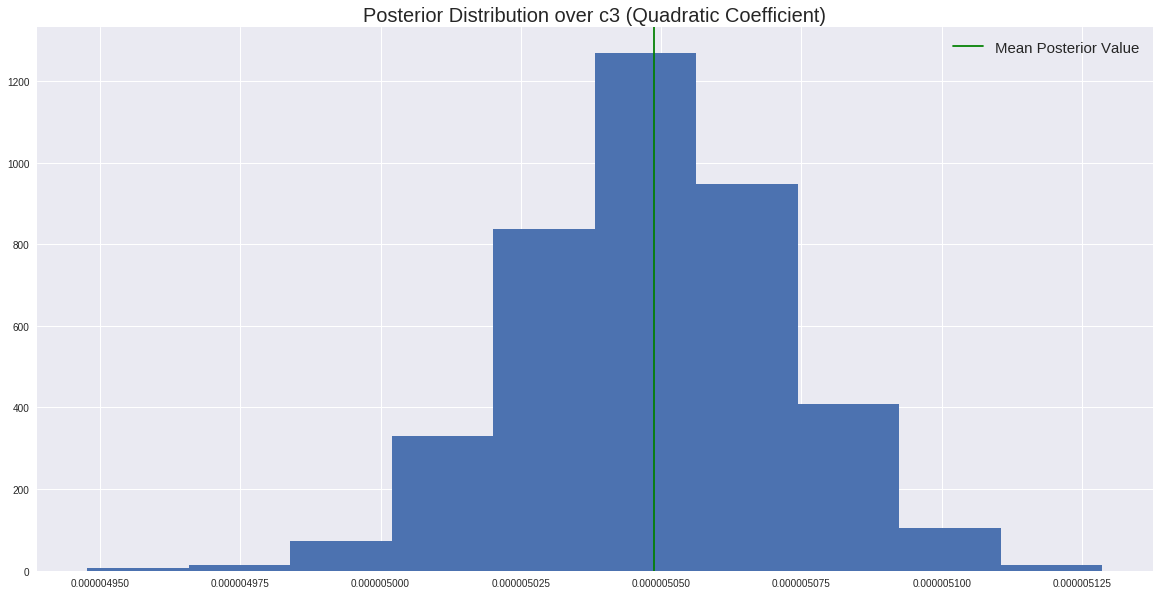

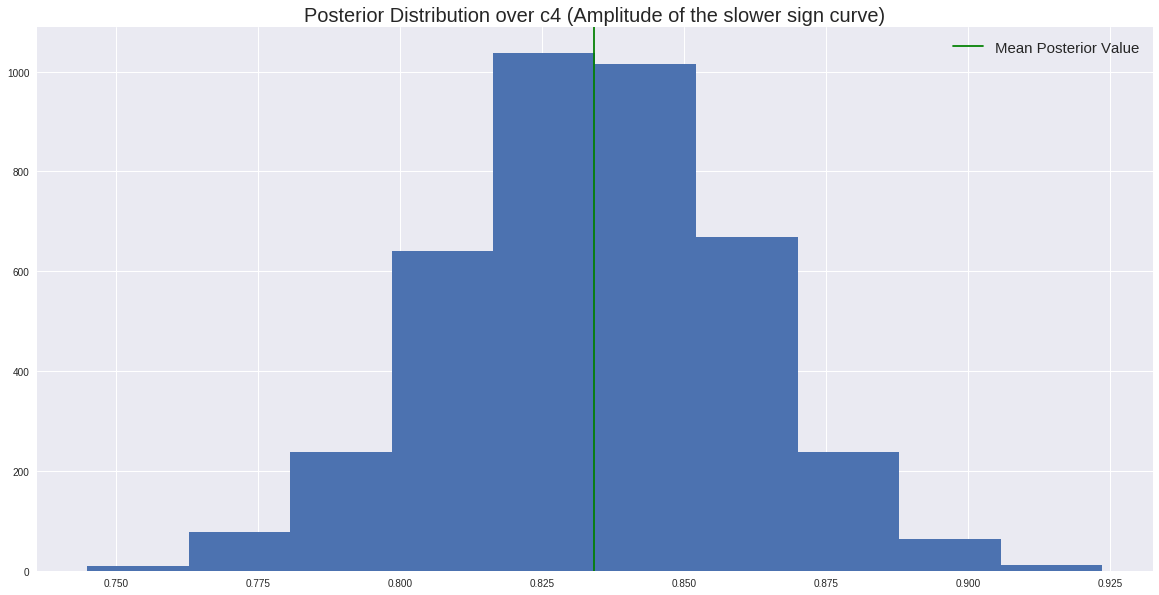

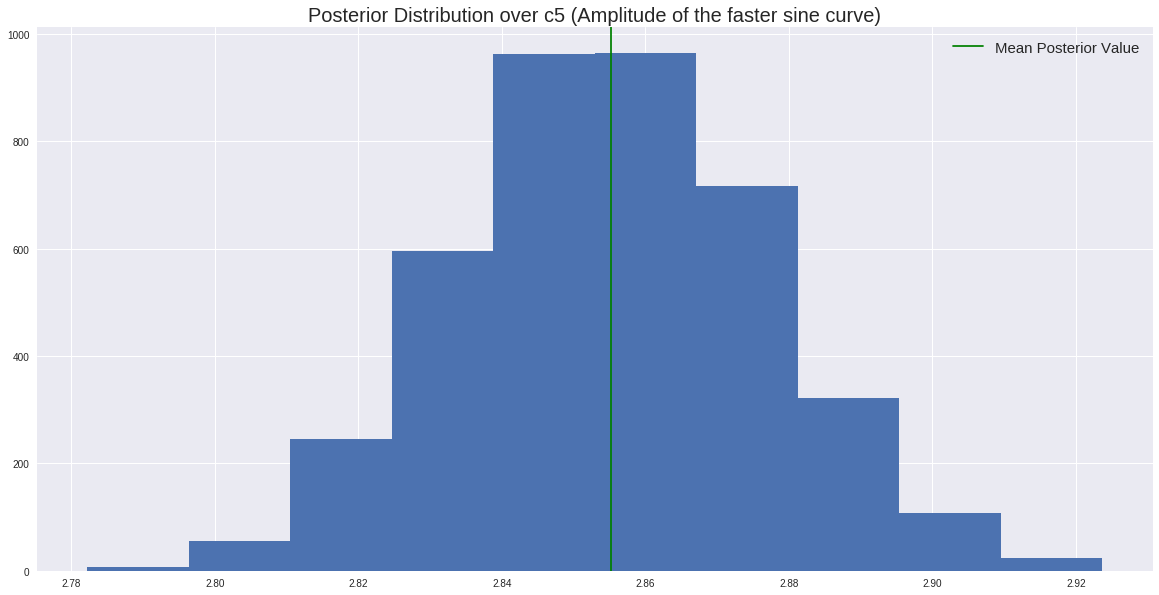

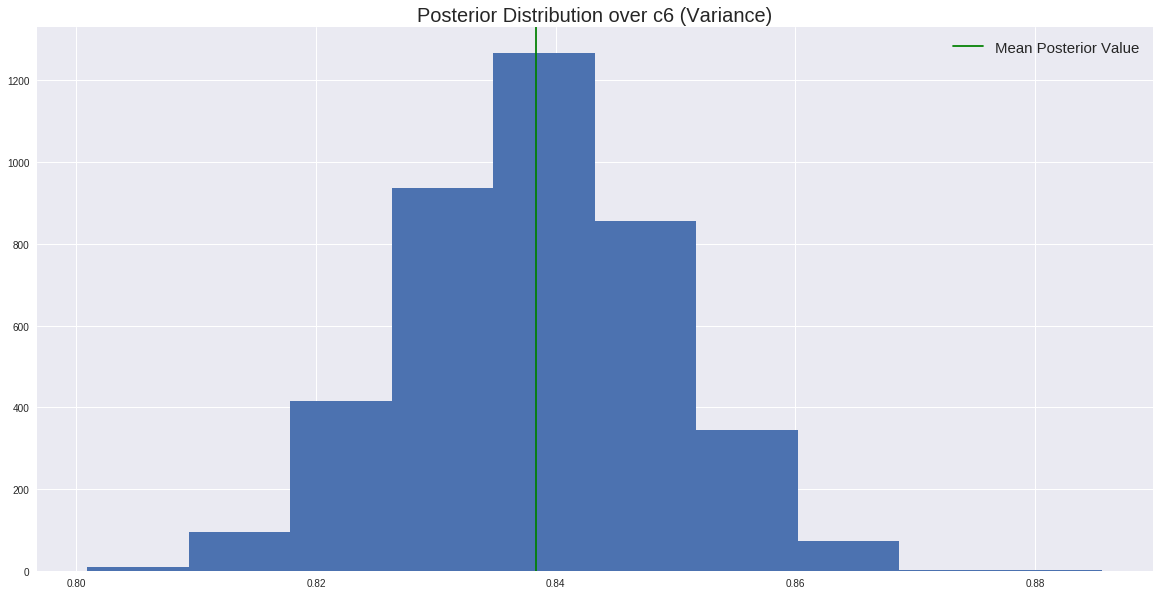

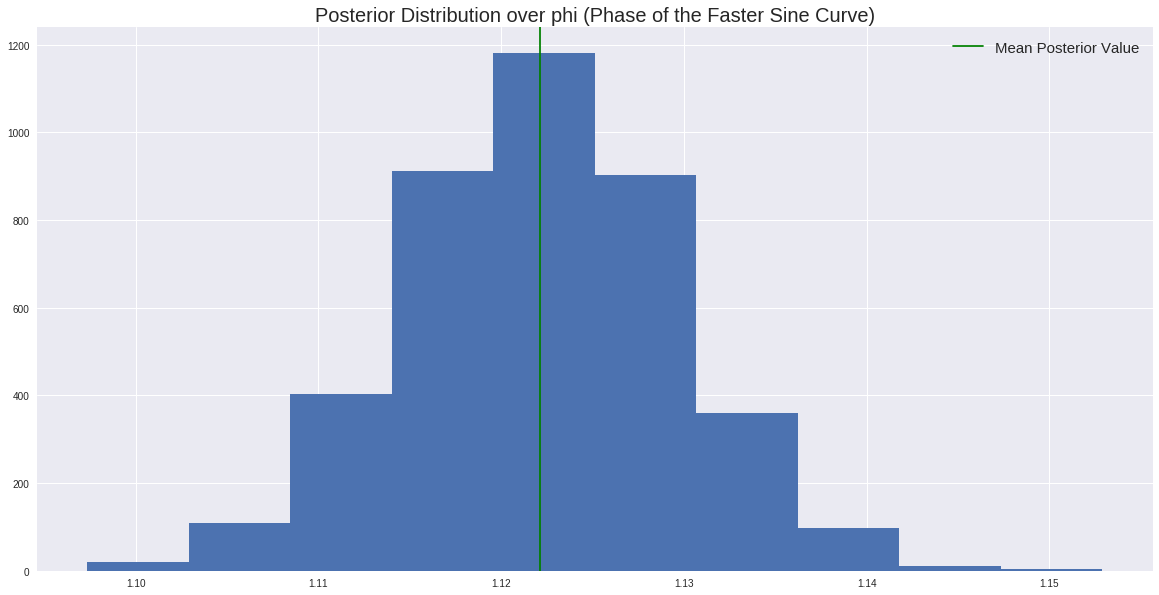

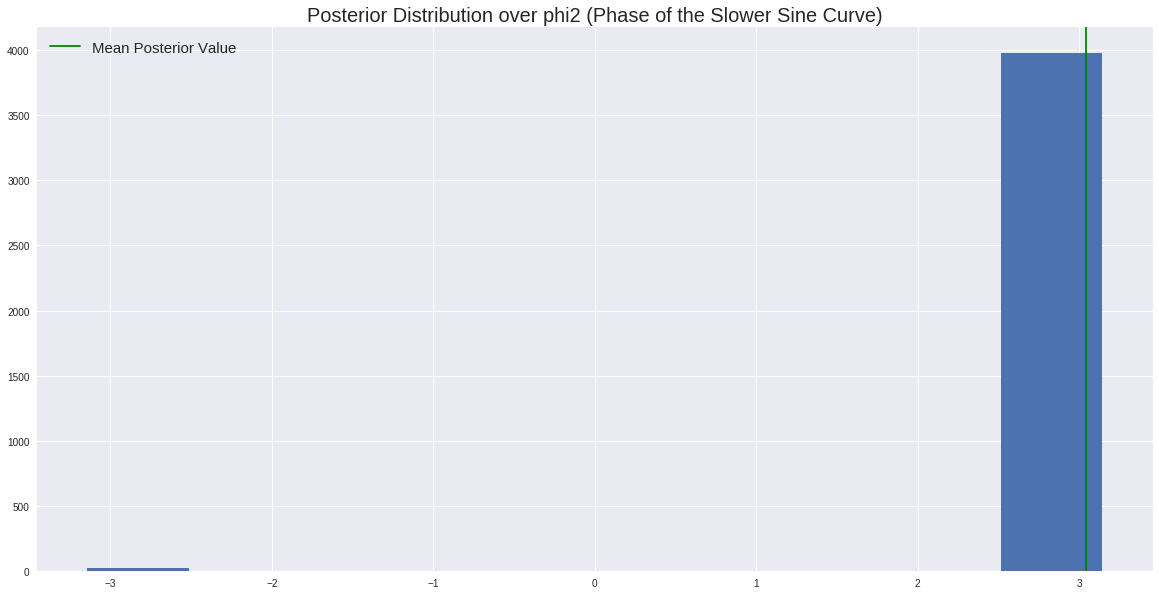

In [0]:
descriptions = ['Intercept','Linear Coefficient','Quadratic Coefficient','Amplitude of the slower sign curve','Amplitude of the faster sine curve','Variance','Phase of the Faster Sine Curve','Phase of the Slower Sine Curve']

for i in range(0,8):
  param = parameters[i]
  samples = posterior_samples[param]
  
  plt.figure(figsize=(20,10))
  plt.hist(samples)
  plt.axvline(np.mean(samples),color='green',label='Mean Posterior Value')
  plt.title('Posterior Distribution over ' + str(param) + ' (' + descriptions[i] + ')', fontsize=20)
  plt.legend(fontsize=15)
  plt.show()
  

# Alternative Models for adjusting confidence intervals

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b9763f50ac1a695d068bf7d10f1431e NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp4pee2g8g/stanfit4anon_model_5b9763f50ac1a695d068bf7d10f1431e_356401006435043960.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_5b9763f50ac1a695d068bf7d10f1431e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1   306.08  5.1e-3   0.13 305.81 305.99 306.08 306.17 306.34    639   1.01
c2     0.03  3.2e-6 7.0e-5   0.03   0.03   0.03   0.03   0.03    473   1.01
c4     1.91  2.6e-3   0.09   1.73   1.84   1.91   1.97   2.08   1203    1.0
c5     2.88  1.9e-3   0.08   2.71   2.82   2.88   2.93   3.04   1941    1.0
c6     3.36 10.0e-4   0.04   3.28   3.33   3.36   3.39   3.45   1917    1.0
phi     1.1  5.0e-4   0.03   1.04   1.08    1.1   1.12   1.16   3746    1.0
phi2  -0.39  8.1e-4   0.05  -0.48  -0.42  -0.39  -0.36   -0.3   3143    1.0

Samples were drawn using NUTS at Thu Dec 20 23:42:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
co

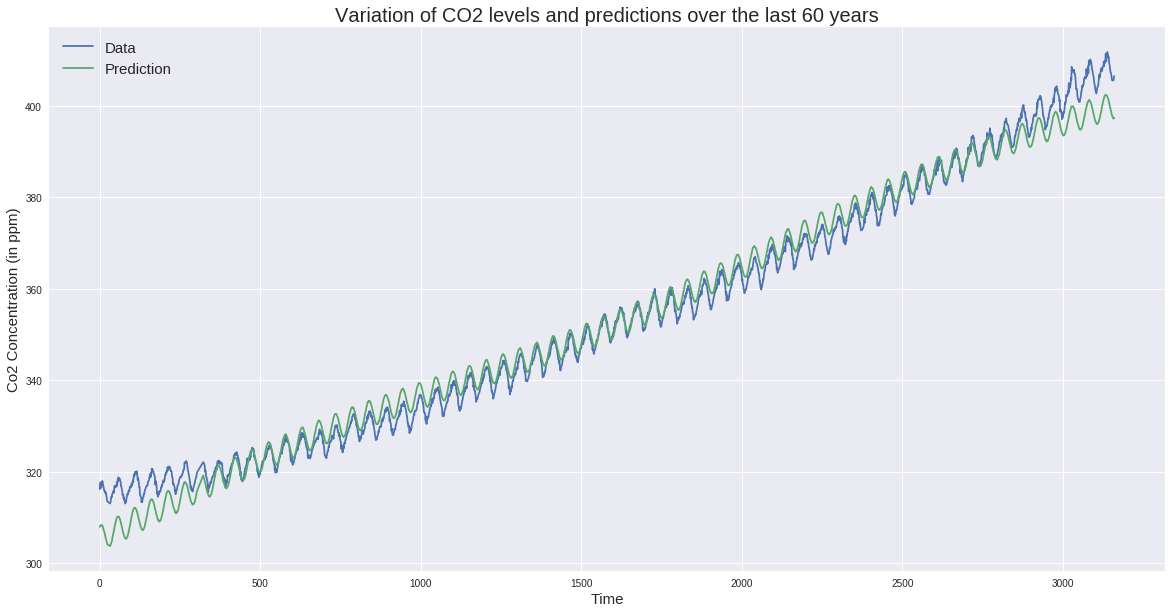

In [0]:
## Just Linear Model

code_2 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> N;  // number of datapoints
    int<lower=1> N_future;
    real<lower=0> ppm[N];  // C02 concentration data
    real<lower=0> week[N_future];
    real<lower=0> period;
    real<lower=0> period2;
    real<lower=0> c6_meanvariance;
    real<lower=0> amp1;
    real<lower=0> amp2;
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c4;
    real<lower=0> c5;
    real<lower=0> c6;
    real phi_x;
    real phi_y;
    
    real phi2_x;
    real phi2_y;
    
}

transformed parameters {
    real<lower= -pi(),upper = pi()> phi;
    real<lower= -pi(),upper = pi()> phi2;
    phi = atan2(phi_x, phi_y);
    phi2 = atan2(phi2_x, phi2_y);
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    
    c1 ~ gamma(100,0.3);
    c2 ~ normal(0.01,0.1);
    c4 ~ normal(amp1,1);
    c5 ~ normal(amp2,1);
    
    c6 ~ normal(c6_meanvariance,1);
  
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    phi2_x ~ normal(0, 1);
    phi2_y ~ normal(0, 1);
    
    for (j in 1:N){
    
      ppm[j] ~ normal(c1 + c2*week[j]+ c4*sin((2*pi()/period)*week[j] + phi2) + c5*sin((2*pi()/period2)*week[j] + phi), c6);
    }
    
}

generated quantities{
  real ppm_pred[N_future];
  for(j in 1:N_future){
    ppm_pred[j] = normal_rng(c1 + c2*week[j] + c4*sin((2*pi()/period)*week[j] + phi2) + c5*sin((2*pi()/period2)*week[j] + phi), c6) ; 
    // This is our posterior predictive distribution
    }

}

"""

stan_model_2 = pystan.StanModel(model_code=code_2)
stan_results_2 = stan_model_2.sampling(data=data)
parameters2 = ['c1','c2','c4','c5','c6','phi','phi2']
print(stan_results_2.stansummary(pars=parameters2))
posterior_samples2 = stan_results_2.extract()

ppm2 = posterior_samples2['ppm_pred']
co2_replicated_trend2 = []
upper_bounds2 = []
lower_bounds2 = []

for i in range(0,3091 + future_weeks):
  co2_replicated_trend2.append(np.mean(ppm2[:,i]))
  
  upper_bounds2.append(np.percentile(ppm2[:,i],97.5))
  lower_bounds2.append(np.percentile(ppm2[:,i],2.5))
  
x = weeks
y2 = co2_replicated_trend2
y1 = df.ppm

plt.figure(figsize=(20,10))
plt.plot(x[0:3091],y1[0:],label='Data')
plt.plot(x[0:3091],y2[0:3091],label='Prediction')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Co2 Concentration (in ppm)',fontsize=15)
plt.title('Variation of CO2 levels and predictions over the last 60 years',fontsize=20)
plt.legend(fontsize=15)
plt.show()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31120a2c7d7fa1db2b75965d3c419d6a NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp96d2rgce/stanfit4anon_model_31120a2c7d7fa1db2b75965d3c419d6a_6166025374503791440.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_31120a2c7d7fa1db2b75965d3c419d6a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1   323.89  1.3e-3   0.08 323.74 323.84 323.89 323.94 324.04   3504    1.0
c2   9.1e-6 2.7e-10 1.7e-8 9.1e-6 9.1e-6 9.1e-6 9.2e-6 9.2e-6   4239    1.0
c4     3.03  1.7e-3   0.08   2.88   2.98   3.03   3.08   3.18   2012    1.0
c5     2.84  1.6e-3   0.07    2.7   2.79   2.84   2.89   2.99   1990    1.0
c6     2.84  7.8e-4   0.04   2.77   2.81   2.84   2.86   2.91   2144    1.0
phi    1.14  4.2e-4   0.03   1.09   1.12   1.14   1.15   1.19   3541    1.0
phi2   2.97  3.9e-4   0.02   2.92   2.95   2.97   2.98   3.01   3758    1.0

Samples were drawn using NUTS at Thu Dec 20 22:40:46 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
co

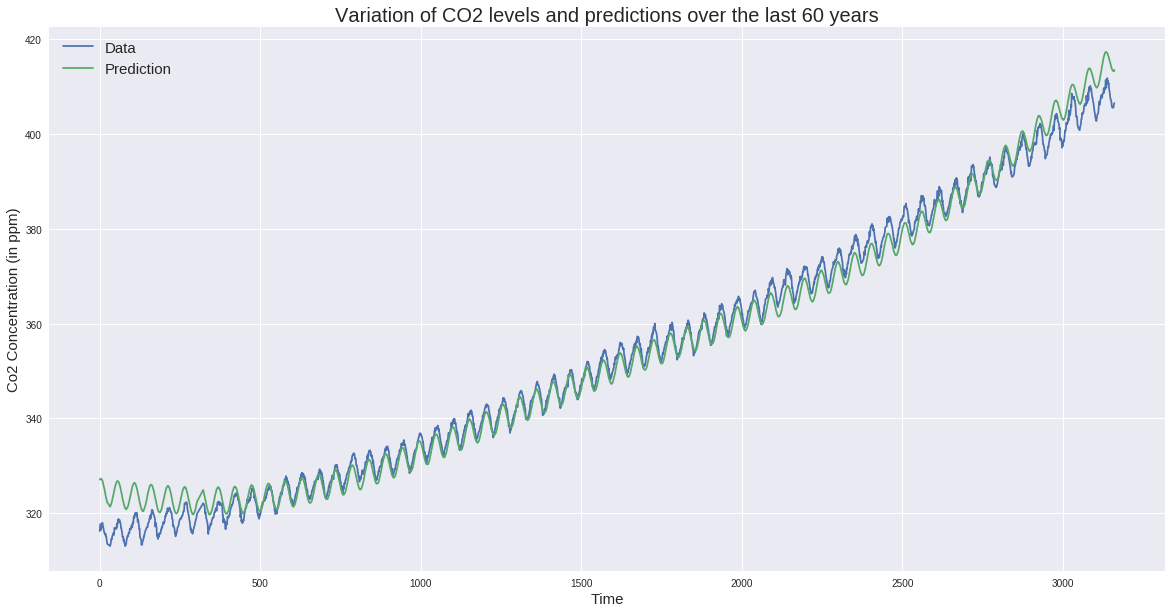

In [0]:
## Just Quadratic Model

code_3 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> N;  // number of datapoints
    int<lower=1> N_future;
    real<lower=0> ppm[N];  // C02 concentration data
    real<lower=0> week[N_future];
    real<lower=0> period;
    real<lower=0> period2;
    real<lower=0> c6_meanvariance;
    real<lower=0> amp1;
    real<lower=0> amp2;
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c4;
    real<lower=0> c5;
    real<lower=0> c6;
    real phi_x;
    real phi_y;
    
    real phi2_x;
    real phi2_y;
    
}

transformed parameters {
    real<lower= -pi(),upper = pi()> phi;
    real<lower= -pi(),upper = pi()> phi2;
    phi = atan2(phi_x, phi_y);
    phi2 = atan2(phi2_x, phi2_y);
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    
    c1 ~ gamma(100,0.3);
    c2 ~ normal(0.01,0.1);
    c4 ~ normal(amp1,1);
    c5 ~ normal(amp2,1);
    
    c6 ~ normal(c6_meanvariance,1);
  
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    phi2_x ~ normal(0, 1);
    phi2_y ~ normal(0, 1);
    
    for (j in 1:N){
    
      ppm[j] ~ normal(c1 + c2*week[j]^2 + c4*sin((2*pi()/period)*week[j] + phi2) + c5*sin((2*pi()/period2)*week[j] + phi), c6);
    }
    
}

generated quantities{
  real ppm_pred[N_future];
  for(j in 1:N_future){
    ppm_pred[j] = normal_rng(c1 + c2*week[j]^2 + c4*sin((2*pi()/period)*week[j] + phi2) + c5*sin((2*pi()/period2)*week[j] + phi), c6) ; 
    // This is our posterior predictive distribution
    }

}

"""

stan_model_3 = pystan.StanModel(model_code=code_3)
stan_results_3 = stan_model_3.sampling(data=data)
parameters3 = ['c1','c2','c4','c5','c6','phi','phi2']
print(stan_results_3.stansummary(pars=parameters3))
posterior_samples3 = stan_results_3.extract()

ppm3 = posterior_samples3['ppm_pred']
co2_replicated_trend3 = []
upper_bounds3 = []
lower_bounds3 = []

for i in range(0,3091 + future_weeks):
  co2_replicated_trend3.append(np.mean(ppm3[:,i]))
  
  upper_bounds3.append(np.percentile(ppm3[:,i],97.5))
  lower_bounds3.append(np.percentile(ppm3[:,i],2.5))
  
x = weeks
y2 = co2_replicated_trend3
y1 = df.ppm

plt.figure(figsize=(20,10))
plt.plot(x[0:3091],y1[0:],label='Data')
plt.plot(x[0:3091],y2[0:3091],label='Prediction')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Co2 Concentration (in ppm)',fontsize=15)
plt.title('Variation of CO2 levels and predictions over the last 60 years',fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Adjusted Confidence Intervals

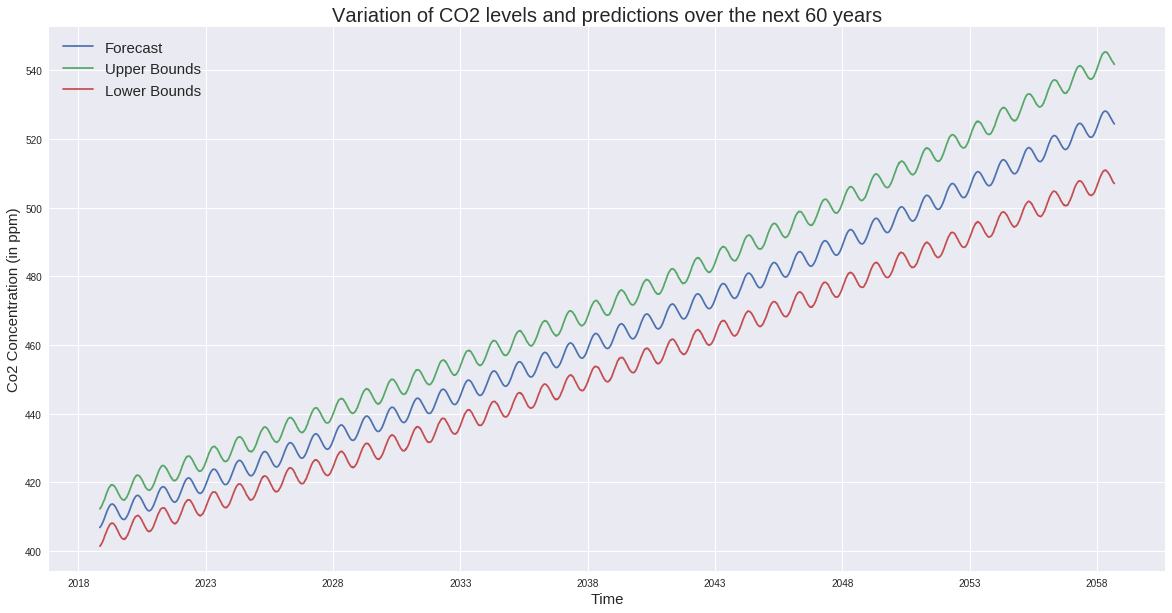

In [0]:
x = timestamps
y1 = co2_replicated_trend
updated_upper = []
updated_lower = []

for i in range(0,future_weeks): # We are weighing the confidence intervals from different models to adjust the uncertainty in our model
  updated_upper.append( 0.5*upper_bounds[i + 3091] + 0.1*upper_bounds2[i + 3091] + 0.4*upper_bounds3[i + 3091])

for i in range(0,future_weeks):
  updated_lower.append(2*y1[i + 3091] - updated_upper[i])

y1 = co2_replicated_trend
y2 = updated_upper
y3 = updated_lower

plt.figure(figsize=(20,10))
plt.plot(x[3091:],y1[3091:],label='Forecast')
plt.plot(x[3091:],y2,label='Upper Bounds')
plt.plot(x[3091:],y3,label='Lower Bounds')

plt.xlabel('Time',fontsize=15)
plt.ylabel('Co2 Concentration (in ppm)',fontsize=15)
plt.title('Variation of CO2 levels and predictions over the next 60 years',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [0]:
print(y2[5135 - 3091]-y1[5135],y3[5135-3091]-y1[5135])

17.07020964519006 -17.07020964519006


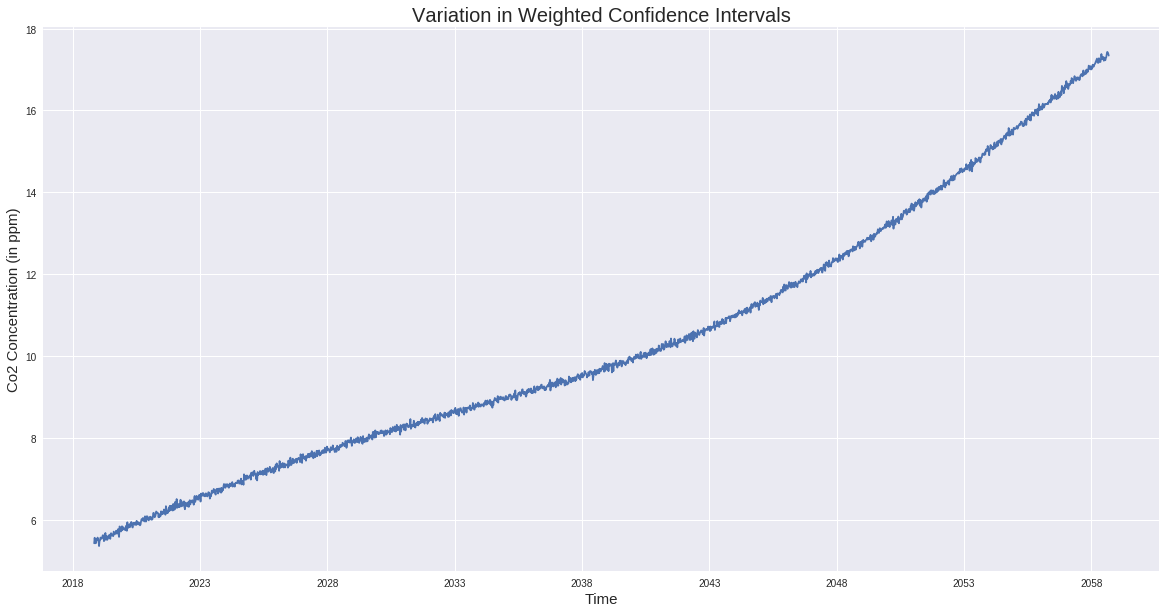

In [0]:
new_diff = []
for i in range(0,future_weeks):
  new_diff.append(updated_upper[i] - co2_replicated_trend[i + 3091])

plt.figure(figsize=(20,10))
plt.plot(timestamps[3091:],new_diff)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Co2 Concentration (in ppm)',fontsize=15)
plt.title('Variation in Weighted Confidence Intervals',fontsize=20)
plt.legend(fontsize=15)
plt.show()